In [ ]:
# ruff: noqa: T201, T203
from __future__ import annotations

import os
from pathlib import Path

if Path.cwd().name == "notebooks":
    os.chdir("..")

import logging

from dotenv import load_dotenv

from config.config import DATA_DIR
from src.evaluate import analyze_results, get_predictions_with_gt, plot_usage_histograms
from src.formatting import (
    format_oracle_pairs_filepath,
    format_run_path,
    format_storing_pathes_from_run_path,
)
from src.LLM_servers.openai import OpenAIServer
from src.onto_access import OntologyAccess
from src.onto_object import OntologyEntryAttr
from src.processing import parallel_samples_process
from src.prompts.system import BASELINE_INITIALIZATION_MESSAGE
from src.result_formatting import print_results_entry
from src.utils import read_oracle_pairs, save_run_results

logging.getLogger().setLevel(logging.WARNING)
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
llm_oracle = OpenAIServer()
llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

In [3]:
DATASET_NAME = "anatomy"
SET_NAME = "human-mouse"
SOURCE_ONTOLOGY = "mouse"
TARGET_ONTOLOGY = "human"

src_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{SOURCE_ONTOLOGY}.owl"
tgt_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{TARGET_ONTOLOGY}.owl"

onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology human <data/anatomy/human-mouse/human.owl#>.
* Owlready2 * ADD TRIPLE data/anatomy/human-mouse/human.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology human from data/anatomy/human-mouse/human.owl...


* Owlready2 * Reseting property oboInOwl.ObsoleteProperty: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasRelatedSynonym: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDefaultNamespace: new triples are now available.
* Owlready2 * Reseting property oboInOwl.savedBy: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDate: new triples are now available.


* Owlready2 *     ...8 properties found: ObsoleteProperty, UNDEFINED_part_of, label, hasRelatedSynonym, hasDefaultNamespace, savedBy, hasDate, hasDefinition


In [ ]:
# access the ontology entry example
entry_uri = "http://human.owl#NCI_C33075"
entry = OntologyEntryAttr(entry_uri, onto_tgt)

print(entry)
print(entry.get_all_entity_names())
print(entry.get_parents_preferred_names())
print(entry.get_children_preferred_names())
print(entry.get_synonyms())
print(entry.get_direct_parents())
print(entry.get_direct_parents().pop().get_direct_children())

print(entry.get_parents_by_levels(max_level=8))

{'class': human.NCI_C33075, 'uri': 'http://human.owl#NCI_C33075', 'preffered_names': {'Meibomian_Gland'}, 'synonyms': {'Meibomian Gland'}, 'all_names': {'Meibomian_Gland', 'Meibomian Gland'}, 'parents': {owl.Thing, human.NCI_C13018, human.NCI_C13319, human.NCI_C12712, human.NCI_C33519, human.NCI_C12219}, 'children': set()}
{'Meibomian_Gland', 'Meibomian Gland'}
[{'Thing'}, {'Organ'}, {'Gland'}, {'Exocrine_Gland'}, {'Sebaceous_Gland'}, {'Anatomic_Structure_System_or_Substance'}]
[]
{'Meibomian Gland'}
{human.NCI_C33519}
{human.NCI_C33075, human.NCI_C33521}
{0: {human.NCI_C33075}, 1: {human.NCI_C33519}, 2: {human.NCI_C12712}, 3: {human.NCI_C13319}, 4: {human.NCI_C13018}, 5: {human.NCI_C12219}, 6: {owl.Thing}}


In [2]:
# experiment with the promts here
# if the promts will become staged in the future - move to the prompt module

def prompt_only_names(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}

    Response with True or False
    """


def prompt_with_hierarchy(src_entety: OntologyEntryAttr, tgt_entety: OntologyEntryAttr) -> str:
    return f"""
    Given two entities from different ontologies with their names, parent relationships, and child relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.get_all_entity_names()}
    Parent Entity Namings: {src_entety.get_parents_preferred_names()}
    Child Entity Namings: {src_entety.get_children_preferred_names()}

    2. Target Entity:
    All Entity names: {tgt_entety.get_all_entity_names()}
    Parent Entity Namings: {tgt_entety.get_parents_preferred_names()}
    Child Entity Namings: {tgt_entety.get_children_preferred_names()}

    Response with True or False
    """  # noqa: E501


Processing Lines prompt_only_names:   0%|          | 0/10 [00:00<?, ?it/s]

Processing Lines prompt_only_names: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Mean input tockens: 157.6
Mean output tockens: 6.0
Total input tockens: 1576
Total output tockens: 60


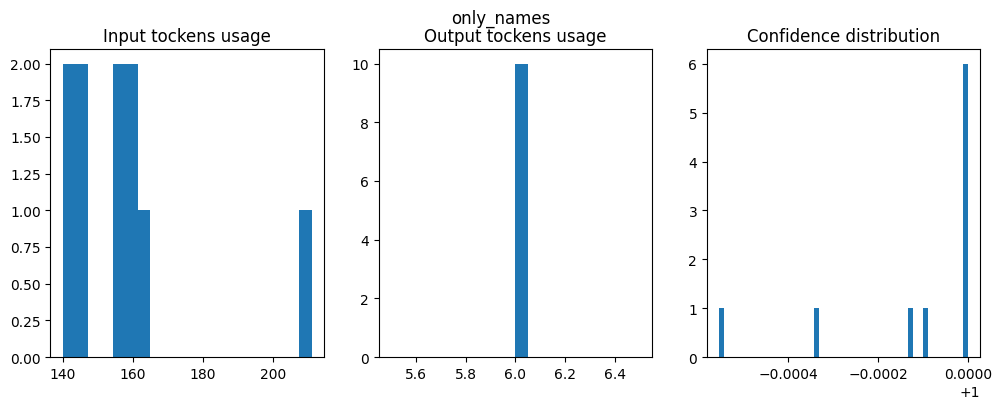

Accuracy: 0.600
Precision: 0.750
Recall: 0.750
F1 Score: 0.750


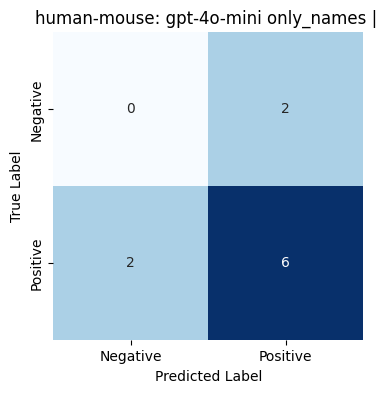

In [ ]:
MAX_WORKERS = 6
MODEL = "gpt-4o-mini"


EXP_NAMES_TO_PROMPT_FUNCTIONS = {
    "only_names": prompt_only_names,
    "with_hierarchy": prompt_with_hierarchy,
}

oracle_candidate_pairs_path = format_oracle_pairs_filepath(DATASET_NAME, SET_NAME)

oracle_candidate_pairs = read_oracle_pairs(oracle_candidate_pairs_path)[:10]

run_path = format_run_path()

for current_exp_name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    results, tokens_usage, confidences = parallel_samples_process(
        oracle_candidate_pairs, llm_oracle, onto_src, onto_tgt, MODEL, MAX_WORKERS, prompt_function
    )
    prediction_path, stats_path, diagram_path = format_storing_pathes_from_run_path(
        run_path, SET_NAME, MODEL, current_exp_name
    )
    save_run_results(results, prediction_path, columns=["Source", "Target", "Prediction", "Confidence"])

    plot_usage_histograms(tokens_usage, confidences, do_plot=True, do_print=True, suptitle=current_exp_name)

    predictions = get_predictions_with_gt(run_path, DATASET_NAME, SET_NAME, MODEL, current_exp_name)
    analyze_results(
        predictions,
        print_results=True,
        plot_confusion_matrix=True,
        subtitle=f"{SET_NAME}: {MODEL} {current_exp_name} | ",
        cm_save_path=diagram_path,
        stats_path=stats_path,
    )
    print("\n\n\n")
    break


Accuracy: 0.600
Precision: 0.750
Recall: 0.750
F1 Score: 0.750


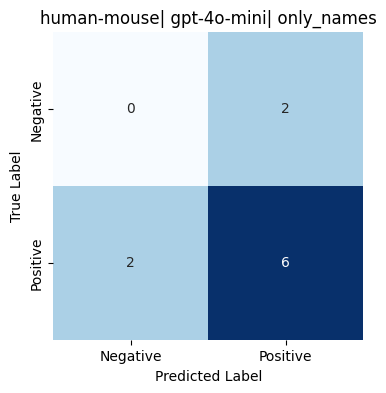

In [8]:
exp_name = "only_names"
predictions = get_predictions_with_gt(run_path,DATASET_NAME, SET_NAME, MODEL, exp_name)
analyze_results(
    predictions, print_results=True, plot_confusion_matrix=True, subtitle=f"{SET_NAME}| {MODEL}| {exp_name}"
);

In [9]:
exp_name = "only_names"
res_df = get_predictions_with_gt(run_path,DATASET_NAME, SET_NAME, model='gpt-4o-mini', exp_name=exp_name)

In [10]:
res_df

,Source,Target,Prediction,Confidence,Label,Type
0,http://human.owl#NCI_C12262,http://mouse.owl#MA_0001615,True,0.999903,True,TP
1,http://human.owl#NCI_C33743,http://mouse.owl#MA_0002390,False,0.999876,True,FN
2,http://human.owl#NCI_C33075,http://mouse.owl#MA_0001249,True,0.999997,True,TP
3,http://human.owl#NCI_C32658,http://mouse.owl#MA_0002684,False,0.999447,True,FN
4,http://human.owl#NCI_C33748,http://mouse.owl#MA_0001221,True,0.999999,True,TP
5,http://human.owl#NCI_C53050,http://mouse.owl#MA_0002234,True,0.999998,False,FP
6,http://human.owl#NCI_C33791,http://mouse.owl#MA_0000777,True,0.999996,True,TP
7,http://human.owl#NCI_C12909,http://mouse.owl#MA_0002434,True,0.999999,True,TP
8,http://human.owl#NCI_C32497,http://mouse.owl#MA_0000451,True,0.999999,True,TP
9,http://human.owl#NCI_C33627,http://mouse.owl#MA_0001460,True,0.999664,False,FP


In [12]:
print_results_entry(res_df, onto_tgt, onto_src, pair_type='FN', idx=0)

Processing pair 0 of type FN
'Source Entry:\n'
{'all_names': {'Temporal Muscle', 'Temporal_Muscle'},
 'children': set(),
 'class': human.NCI_C33743,
 'parents': {owl.Thing,
             human.NCI_C12219,
             human.NCI_C25769,
             human.NCI_C32716,
             human.NCI_C33147,
             human.NCI_C32221,
             human.NCI_C13056},
 'preffered_names': {'Temporal_Muscle'},
 'synonyms': {'Temporal Muscle'},
 'uri': 'http://human.owl#NCI_C33743'}
'Target Entry:\n'
{'all_names': {'temporalis'},
 'children': set(),
 'class': mouse.MA_0002390,
 'parents': {mouse.MA_0000165, mouse.MA_0000015, owl.Thing},
 'preffered_names': {'temporalis'},
 'synonyms': {'MA_0002390'},
 'uri': 'http://mouse.owl#MA_0002390'}
Parent of Source Concept: [{'Head_and_Neck_Muscle'}, {'Anatomic_Structure_System_or_Substance'}, {'Musculoskeletal_System_Part'}, {'Thing'}, {'Muscle_of_the_Mastication'}, {'Body_Part'}, {'Muscle'}]
Parent of Target Concept: [{'skeletal muscle'}, {'muscle'}, {'Thin